<a href="https://colab.research.google.com/github/jayadevgnvrama/Ensemble-Deep-Learning-for-Parkinson-s-Disease-A-Comparative-Study-of-CNN-models-/blob/main/EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.9 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=7b676508ca62c77f49091be3fd006af40513f49f8d13fc59d

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
from google.colab import drive
from PIL import Image
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths for train, test, and validation data
train_path = '/content/drive/MyDrive/TRAIN_CROP'
test_path = '/content/drive/MyDrive/TEST_CROP'
val_path = '/content/drive/MyDrive/VAL_CROP'

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
batch_size = 30
num_epochs = 30

train_loader = DataLoader(ImageFolder(train_path, transform=transform_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ImageFolder(val_path, transform=transform_test), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(ImageFolder(test_path, transform=transform_test), batch_size=batch_size, shuffle=False)


In [2]:
# Load EfficientNet-B0 model
efficientnet_b0 = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier for 2 classes (Parkinson's vs Non-Parkinson's)
num_classes = 2
efficientnet_b0._fc = nn.Linear(efficientnet_b0._fc.in_features, num_classes)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 112MB/s]
Loaded pretrained weights for efficientnet-b0


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_b0.parameters(), lr=0.001)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_b0.to(device)

accuracy_list = []
loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    efficientnet_b0.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_b0(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_accuracy = 100 * total_correct / total_samples
    accuracy_list.append(epoch_accuracy)
    loss_list.append(running_loss / len(train_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch [1/30], Loss: 1.1424, Accuracy: 60.92%
Epoch [2/30], Loss: 0.4706, Accuracy: 76.82%
Epoch [3/30], Loss: 0.2699, Accuracy: 88.31%
Epoch [4/30], Loss: 0.2212, Accuracy: 91.38%
Epoch [5/30], Loss: 0.2233, Accuracy: 93.10%
Epoch [6/30], Loss: 0.1859, Accuracy: 93.49%
Epoch [7/30], Loss: 0.1571, Accuracy: 94.64%
Epoch [8/30], Loss: 0.1311, Accuracy: 94.44%
Epoch [9/30], Loss: 0.1238, Accuracy: 95.79%
Epoch [10/30], Loss: 0.1229, Accuracy: 95.40%
Epoch [11/30], Loss: 0.1259, Accuracy: 94.64%
Epoch [12/30], Loss: 0.1406, Accuracy: 94.25%
Epoch [13/30], Loss: 0.1462, Accuracy: 95.02%
Epoch [14/30], Loss: 0.1464, Accuracy: 95.02%
Epoch [15/30], Loss: 0.1843, Accuracy: 91.95%
Epoch [16/30], Loss: 0.1386, Accuracy: 95.02%
Epoch [17/30], Loss: 0.1037, Accuracy: 96.17%
Epoch [18/30], Loss: 0.1088, Accuracy: 96.55%
Epoch [19/30], Loss: 0.0948, Accuracy: 96.55%
Epoch [20/30], Loss: 0.0936, Accuracy: 97.13%
Epoch [21/30], Loss: 0.1207, Accuracy: 96.74%
Epoch [22/30], Loss: 0.1060, Accuracy: 96.3

In [5]:
# Save the trained model
torch.save(efficientnet_b0.state_dict(), model_save_path)
print("Model saved successfully!")


Model saved successfully!


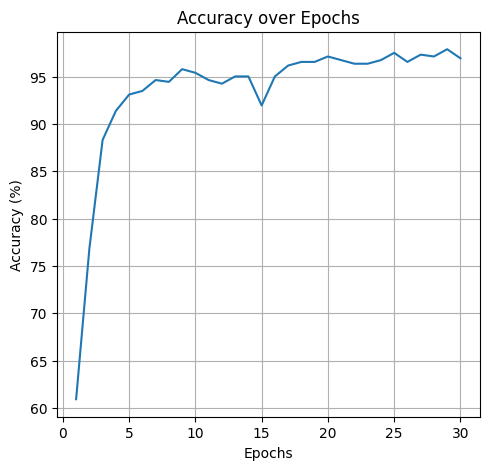

In [ ]:
plt.plot(range(1, num_epochs + 1), accuracy_list, label="Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epoch')
plt.legend()
plt.show()




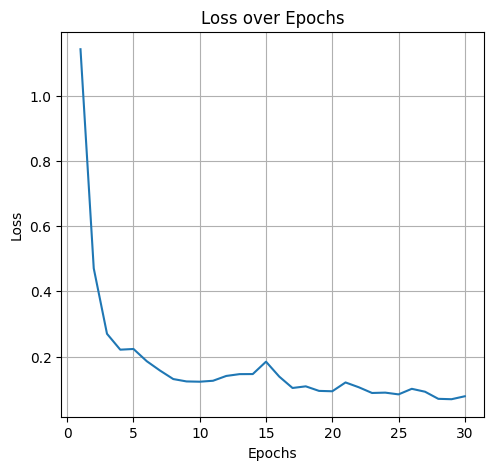

In [ ]:
plt.plot(range(1, num_epochs + 1), loss_list, label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epoch')
plt.legend()
plt.show()

In [6]:
efficientnet_b0.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_b0(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Validation Accuracy: 95.95%


In [7]:
efficientnet_b0.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_b0(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 95.38%


In [ ]:
actual, prediction = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_b0(images)
        _, predicted = torch.max(outputs, 1)
        actual.extend(labels.cpu().tolist())
        prediction.extend(predicted.cpu().tolist())

# Classification Report
print("Classification Report:\n", classification_report(actual, prediction, target_names=["Non-PD", "PD"]))


Classification Report:
              precision    recall  f1-score   support

      Non-PD       0.91      0.95      0.93        22
          PD       0.98      0.95      0.96        43

    accuracy                           0.95        65
   macro avg       0.94      0.95      0.95        65
weighted avg       0.95      0.95      0.95        65



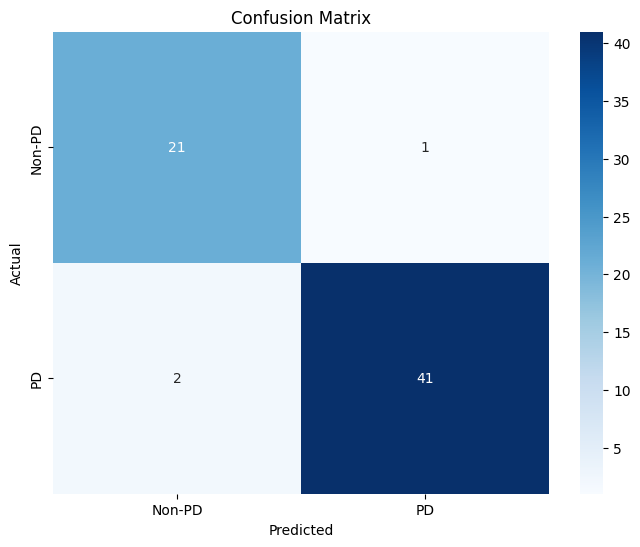

In [ ]:
# Compute confusion matrix
confusion_mtx = confusion_matrix(actual, prediction)
sn.heatmap(confusion_mtx, annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix")
plt.show()

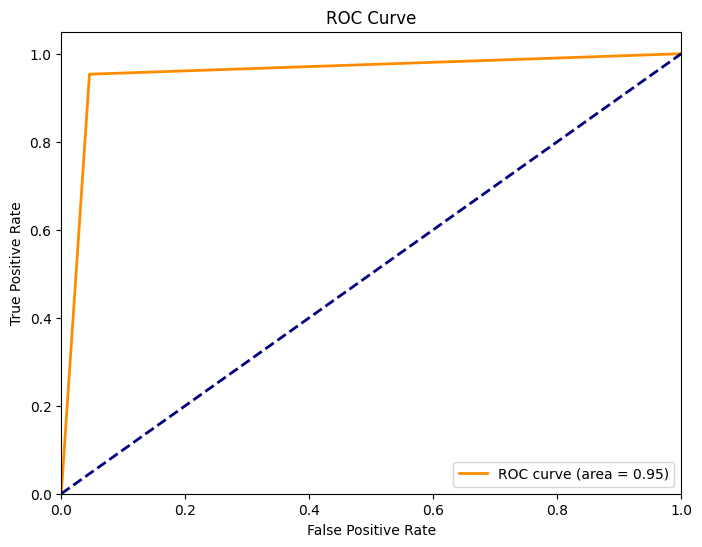

In [ ]:
fpr, tpr, _ = roc_curve(actual, prediction)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
